In [55]:
from fbprophet import Prophet
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import optuna
from fbprophet.diagnostics import cross_validation, performance_metrics

In [56]:
df = pd.read_csv("google-data.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [58]:
df.Date = df.Date.apply(pd.to_datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1259 non-null   datetime64[ns]
 1   Open       1259 non-null   float64       
 2   High       1259 non-null   float64       
 3   Low        1259 non-null   float64       
 4   Close      1259 non-null   float64       
 5   Adj Close  1259 non-null   float64       
 6   Volume     1259 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 69.0 KB


In [59]:
data = df[["Date","Close"]]
data.columns = ["ds", "y"]
data.head()

,ds,y
0,2013-01-02,359.288177
1,2013-01-03,359.496826
2,2013-01-04,366.600616
3,2013-01-07,365.001007
4,2013-01-08,364.280701


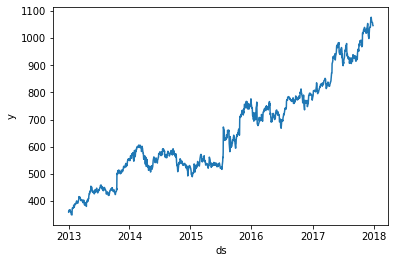

In [60]:
sns.lineplot(x=data.ds, y=data.y)
plt.show()

In [61]:
train = data.iloc[:-100,]
test = data.iloc[-100:]
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [62]:
forecast = model.make_future_dataframe(periods = 100, freq= "D")
predictions = model.predict(forecast)
forecast.shape

(1259, 1)

In [63]:
forecast.shape

(1259, 1)

In [64]:
predictions.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-02,386.997704,346.730706,398.858168,386.997704,386.997704,-14.746664,-14.746664,-14.746664,6.879679,6.879679,6.879679,-21.626343,-21.626343,-21.626343,0.0,0.0,0.0,372.251039
1,2013-01-03,387.169039,341.160108,395.553866,387.169039,387.169039,-16.293346,-16.293346,-16.293346,5.926867,5.926867,5.926867,-22.220213,-22.220213,-22.220213,0.0,0.0,0.0,370.875693
2,2013-01-04,387.340375,344.022764,394.904254,387.340375,387.340375,-16.544963,-16.544963,-16.544963,6.222136,6.222136,6.222136,-22.767100,-22.767100,-22.767100,0.0,0.0,0.0,370.795412
3,2013-01-07,387.854382,346.344902,394.799188,387.854382,387.854382,-18.135633,-18.135633,-18.135633,5.974312,5.974312,5.974312,-24.109944,-24.109944,-24.109944,0.0,0.0,0.0,369.718749
4,2013-01-08,388.025718,345.608773,396.783656,388.025718,388.025718,-18.246958,-18.246958,-18.246958,6.210030,6.210030,6.210030,-24.456988,-24.456988,-24.456988,0.0,0.0,0.0,369.778760


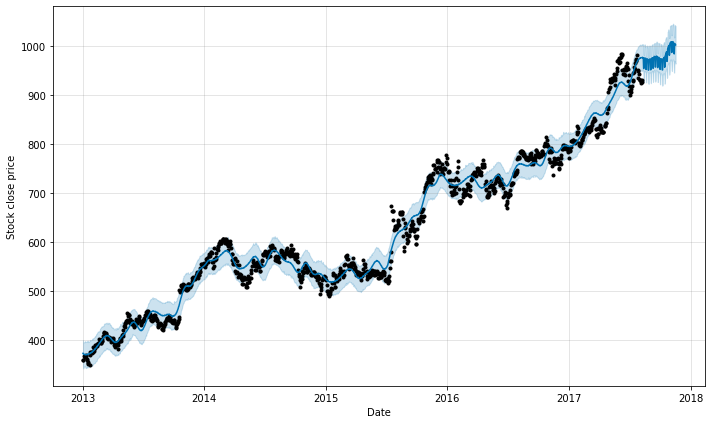

In [65]:
preds = predictions[["ds", "yhat"]]
model.plot(predictions, xlabel = "Date", ylabel= "Stock close price");


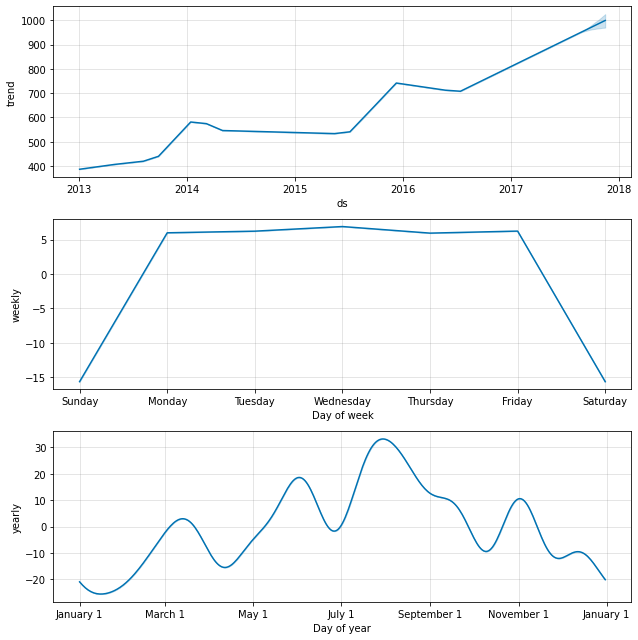

In [66]:
model.plot_components(predictions);

In [67]:
preds.shape


(1259, 2)

In [68]:
y_pred = preds.iloc[-100:, 1]
y_test = test.y
y_pred

1159     976.612423
1160     975.564497
1161     975.723284
1162     953.721062
1163     953.514837
           ...     
1254     983.563052
1255    1004.381091
1256    1003.835059
1257    1003.725988
1258    1002.018702
Name: yhat, Length: 100, dtype: float64

In [69]:
y_test

1159     922.900024
1160     907.239990
1161     914.390015
1162     922.669983
1163     922.219971
           ...     
1254    1060.119995
1255    1056.739990
1256    1049.369995
1257    1048.140015
1258    1046.400024
Name: y, Length: 100, dtype: float64

In [70]:
def rmse(y_t, y_p):
  return float(np.sqrt(mean_squared_error(y_true= y_test, y_pred= y_pred)))

rmse(y_test, y_pred)

44.31477243427674

In [71]:
data.shape


(1259, 2)

In [73]:
m = Prophet()
m.fit(data) 

number_initial_days = 366

sample_cv = cross_validation(m,
                         initial=f'{number_initial_days} days', 
                         period='180 days', 
                         horizon = '100 days',
                         parallel='processes')

sample_p = performance_metrics(sample_cv)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2014-04-09 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f835c92b290>


In [74]:
param_types = {'changepoint_prior_scale': 'float', 
               'seasonality_prior_scale': 'float',
              'seasonality_mode': 'int'}

bounds = {'changepoint_prior_scale': [0.001, 0.5],
          'seasonality_prior_scale': [0.01, 10],
          'seasonality_mode': [0, 1]}  #0 for additive, 1 for multiplicative

In [77]:
def objective(trial):
    '''Train a prophet model and return the rmse'''
    # sampling
    params = {}
    for param in ['changepoint_prior_scale', 'seasonality_prior_scale']:
        params[param] = trial.suggest_uniform(param, bounds[param][0], bounds[param][1])
        
    stationality = ['additive', 'multiplicative']
    params['seasonality_mode'] = stationality[trial.suggest_int('seasonality_mode', 
                                                                  bounds['seasonality_mode'][0], 
                                                                  bounds['seasonality_mode'][1])]

    # modeling
    m = Prophet(weekly_seasonality=True,
                daily_seasonality=False,
                **params)
    
    m.fit(data) 
    number_initial_days = 500
    df_cv = cross_validation(m, 
                             initial=f'{number_initial_days} days', 
                             period='180 days', 
                         horizon = '100 days',
                         parallel='processes')
    
    df_p = performance_metrics(df_cv, rolling_window=1)
    print(df_p['mape'].mean())
    
    return df_p['rmse'].values[0]


In [78]:
study = optuna.create_study()
study.optimize(objective, n_trials = 10)

[I 2021-10-19 18:08:11,082] A new study created in memory with name: no-name-ad3ac744-f7a7-4dd7-a083-4200e83dead1
INFO:fbprophet:Making 7 forecasts with cutoffs between 2014-10-06 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8361578f10>
[I 2021-10-19 18:08:52,993] Trial 0 finished with value: 101.16082816290503 and parameters: {'changepoint_prior_scale': 0.07308793606972622, 'seasonality_prior_scale': 8.181034968312062, 'seasonality_mode': 1}. Best is trial 0 with value: 101.16082816290503.


0.11251829525051374


INFO:fbprophet:Making 7 forecasts with cutoffs between 2014-10-06 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f835c79dd10>
[I 2021-10-19 18:09:19,885] Trial 1 finished with value: 89.2302120245009 and parameters: {'changepoint_prior_scale': 0.4264248674628631, 'seasonality_prior_scale': 8.197582857836776, 'seasonality_mode': 0}. Best is trial 1 with value: 89.2302120245009.


0.10121651200463126


INFO:fbprophet:Making 7 forecasts with cutoffs between 2014-10-06 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f835c9481d0>
[I 2021-10-19 18:10:05,769] Trial 2 finished with value: 132.93524695532707 and parameters: {'changepoint_prior_scale': 0.32091942915488486, 'seasonality_prior_scale': 3.6624274292112227, 'seasonality_mode': 1}. Best is trial 1 with value: 89.2302120245009.


0.1484096418733071


INFO:fbprophet:Making 7 forecasts with cutoffs between 2014-10-06 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f836004b710>
[I 2021-10-19 18:10:50,466] Trial 3 finished with value: 126.45686585387382 and parameters: {'changepoint_prior_scale': 0.3121811600202409, 'seasonality_prior_scale': 6.646602595728371, 'seasonality_mode': 1}. Best is trial 1 with value: 89.2302120245009.


0.13534352624501925


INFO:fbprophet:Making 7 forecasts with cutoffs between 2014-10-06 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f835c9481d0>
[I 2021-10-19 18:11:08,431] Trial 4 finished with value: 83.24364051026872 and parameters: {'changepoint_prior_scale': 0.03982695985427442, 'seasonality_prior_scale': 0.43997897285812615, 'seasonality_mode': 0}. Best is trial 4 with value: 83.24364051026872.


0.09224405708377488


INFO:fbprophet:Making 7 forecasts with cutoffs between 2014-10-06 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f836004b710>
[I 2021-10-19 18:11:35,877] Trial 5 finished with value: 89.94959563178747 and parameters: {'changepoint_prior_scale': 0.2741986707707929, 'seasonality_prior_scale': 9.750809298299687, 'seasonality_mode': 0}. Best is trial 4 with value: 83.24364051026872.


0.1003460167115182


INFO:fbprophet:Making 7 forecasts with cutoffs between 2014-10-06 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f835c7a5390>
[I 2021-10-19 18:11:53,744] Trial 6 finished with value: 83.57970059484998 and parameters: {'changepoint_prior_scale': 0.047318051824907656, 'seasonality_prior_scale': 0.8138304349968223, 'seasonality_mode': 0}. Best is trial 4 with value: 83.24364051026872.


0.09306909126959467


INFO:fbprophet:Making 7 forecasts with cutoffs between 2014-10-06 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f835c7a5ed0>
[I 2021-10-19 18:12:22,190] Trial 7 finished with value: 92.21266730207675 and parameters: {'changepoint_prior_scale': 0.22152270327146112, 'seasonality_prior_scale': 1.9685517942840465, 'seasonality_mode': 0}. Best is trial 4 with value: 83.24364051026872.


0.10153095264427975


INFO:fbprophet:Making 7 forecasts with cutoffs between 2014-10-06 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f835c66b090>
[I 2021-10-19 18:12:49,454] Trial 8 finished with value: 88.99203770996934 and parameters: {'changepoint_prior_scale': 0.38343269676321506, 'seasonality_prior_scale': 0.06825434513452422, 'seasonality_mode': 0}. Best is trial 4 with value: 83.24364051026872.


0.09982043713332313


INFO:fbprophet:Making 7 forecasts with cutoffs between 2014-10-06 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f835c6a4a90>
[I 2021-10-19 18:13:30,038] Trial 9 finished with value: 122.45666395343112 and parameters: {'changepoint_prior_scale': 0.4066552456932229, 'seasonality_prior_scale': 7.6320760048686695, 'seasonality_mode': 1}. Best is trial 4 with value: 83.24364051026872.


0.1389837528394625


In [79]:
study.best_params


{'changepoint_prior_scale': 0.03982695985427442,
 'seasonality_mode': 0,
 'seasonality_prior_scale': 0.43997897285812615}

In [80]:
train

,ds,y
0,2013-01-02,359.288177
1,2013-01-03,359.496826
2,2013-01-04,366.600616
3,2013-01-07,365.001007
4,2013-01-08,364.280701
...,...,...
1154,2017-08-02,930.390015
1155,2017-08-03,923.650024
1156,2017-08-04,927.960022
1157,2017-08-07,929.359985


In [81]:
test

,ds,y
1159,2017-08-09,922.900024
1160,2017-08-10,907.239990
1161,2017-08-11,914.390015
1162,2017-08-14,922.669983
1163,2017-08-15,922.219971
...,...,...
1254,2017-12-22,1060.119995
1255,2017-12-26,1056.739990
1256,2017-12-27,1049.369995
1257,2017-12-28,1048.140015


In [82]:
params = study.best_params


In [83]:
params["seasonality_mode"] = "additive"


In [84]:
model = Prophet(weekly_seasonality=True,
                daily_seasonality=False,
                **params)

model.fit(train)
forecast = model.make_future_dataframe(periods = 100, freq= "D")
predictions = model.predict(forecast)
preds = predictions[["ds", "yhat"]]
y_pred = preds.iloc[-100:, 1]
y_test = test.y

In [85]:
rmse(y_test, y_pred)


41.075615585393024

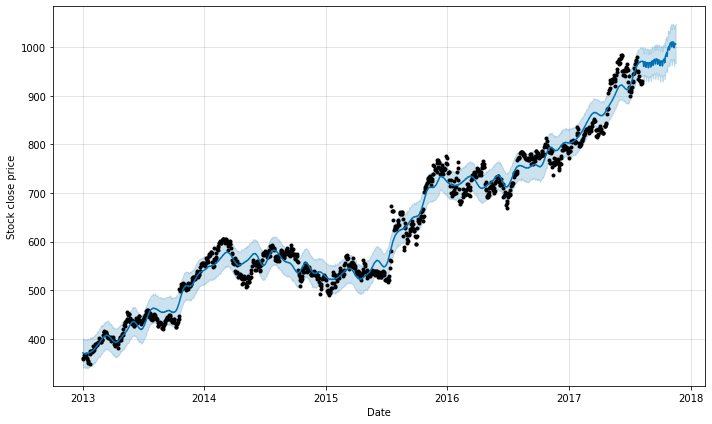

In [86]:
model.plot(predictions, xlabel = "Date", ylabel= "Stock close price");


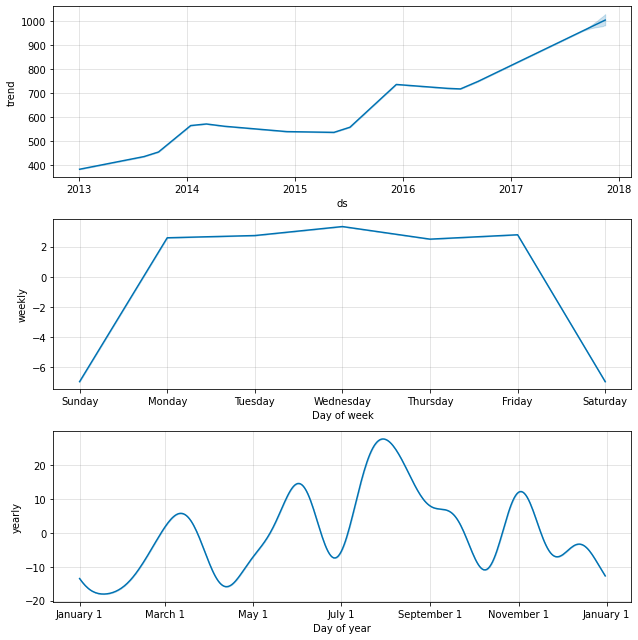

In [87]:
model.plot_components(predictions);
